In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy


In [2]:
df = pd.read_csv('MSFT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400
...,...,...,...,...,...,...,...
9489,2023-11-06,353.450012,357.540009,353.350006,356.529999,356.529999,23828300
9490,2023-11-07,359.399994,362.459991,357.630005,360.529999,360.529999,25833900
9491,2023-11-08,361.679993,363.869995,360.549988,363.200012,363.200012,26767800
9492,2023-11-09,362.299988,364.790009,360.359985,360.690002,360.690002,24847300


In [3]:
df = df[['Date','Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9489,2023-11-06,356.529999
9490,2023-11-07,360.529999
9491,2023-11-08,363.200012
9492,2023-11-09,360.690002


In [4]:
def str_to_datetime(s):
    split = s.split('-')
    year,month,day = int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year,month=month,day=day)

In [5]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

C:\Users\visha\AppData\Local\Temp\ipykernel_6812\2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9489   2023-11-06
9490   2023-11-07
9491   2023-11-08
9492   2023-11-09
9493   2023-11-10
Name: Date, Length: 9494, dtype: datetime64[ns]

In [6]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-11-06,356.529999
2023-11-07,360.529999
2023-11-08,363.200012


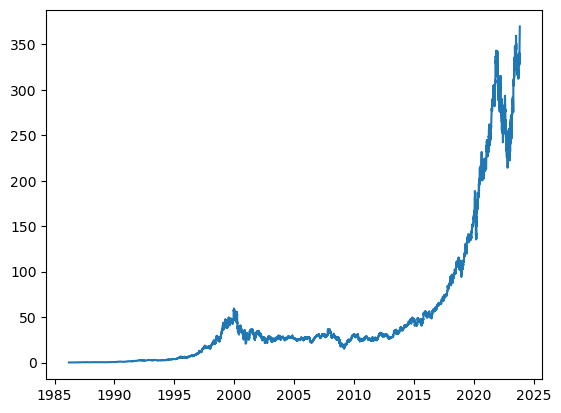

In [7]:
plt.plot(df.index,df['Close'])

In [8]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2023-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
498,2023-03-17,260.790009,265.440002,276.200012,279.429993
499,2023-03-20,265.440002,276.200012,279.429993,272.230011
500,2023-03-21,276.200012,279.429993,272.230011,273.779999
501,2023-03-22,279.429993,272.230011,273.779999,272.290009


In [9]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((503,), (503, 3, 1), (503,))

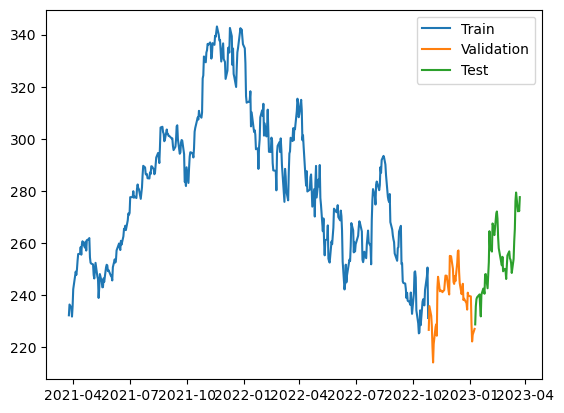

In [10]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [11]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 [==============================] - 4s 58ms/step - loss: 79808.4297 - mean_absolute_error: 281.0294 - val_loss: 56997.3711 - val_mean_absolute_error: 238.5250
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 79311.9922 - mean_absolute_error: 280.1455 - val_loss: 56507.4648 - val_mean_absolute_error: 237.4958
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 78633.7656 - mean_absolute_error: 278.9312 - val_loss: 55760.0156 - val_mean_absolute_error: 235.9168
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 77500.1328 - mean_absolute_error: 276.8922 - val_loss: 54505.2305 - val_mean_absolute_error: 233.2420
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 75726.9531 - mean_absolute_error: 273.6712 - val_loss: 52660.1797 - val_mean_absolute_error: 229.2525
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 73226.6797 - mean_absolute_error: 269.0620 - val_lo

13/13 [==============================] - 0s 5ms/step - loss: 156.5260 - mean_absolute_error: 9.3019 - val_loss: 255.5124 - val_mean_absolute_error: 15.0503
Epoch 49/100
13/13 [==============================] - 0s 5ms/step - loss: 135.0499 - mean_absolute_error: 8.8294 - val_loss: 113.4658 - val_mean_absolute_error: 9.6477
Epoch 50/100
13/13 [==============================] - 0s 5ms/step - loss: 99.9714 - mean_absolute_error: 7.2429 - val_loss: 70.1572 - val_mean_absolute_error: 7.1802
Epoch 51/100
13/13 [==============================] - 0s 5ms/step - loss: 81.7522 - mean_absolute_error: 6.5717 - val_loss: 45.8392 - val_mean_absolute_error: 5.5991
Epoch 52/100
13/13 [==============================] - 0s 5ms/step - loss: 71.1652 - mean_absolute_error: 6.0817 - val_loss: 37.5114 - val_mean_absolute_error: 4.8626
Epoch 53/100
13/13 [==============================] - 0s 4ms/step - loss: 61.3852 - mean_absolute_error: 5.6724 - val_loss: 37.0409 - val_mean_absolute_error: 4.8264
Epoch 54/100

13/13 [==============================] - 0s 5ms/step - loss: 31.8499 - mean_absolute_error: 4.4489 - val_loss: 32.5991 - val_mean_absolute_error: 4.3755
Epoch 98/100
13/13 [==============================] - 0s 4ms/step - loss: 29.4385 - mean_absolute_error: 4.2490 - val_loss: 46.0792 - val_mean_absolute_error: 5.5994
Epoch 99/100
13/13 [==============================] - 0s 5ms/step - loss: 28.3602 - mean_absolute_error: 4.0688 - val_loss: 29.3848 - val_mean_absolute_error: 4.0487
Epoch 100/100
13/13 [==============================] - 0s 4ms/step - loss: 31.5145 - mean_absolute_error: 4.4370 - val_loss: 54.4563 - val_mean_absolute_error: 6.2636


13/13 [==============================] - 0s 1ms/step


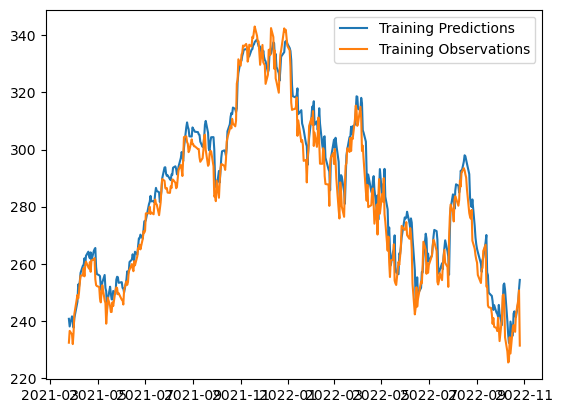

In [20]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 3ms/step


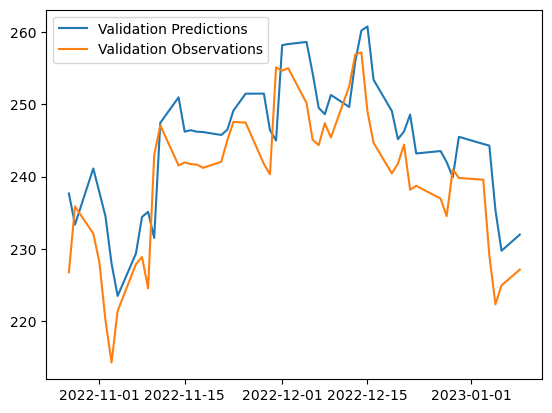

In [19]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 1ms/step


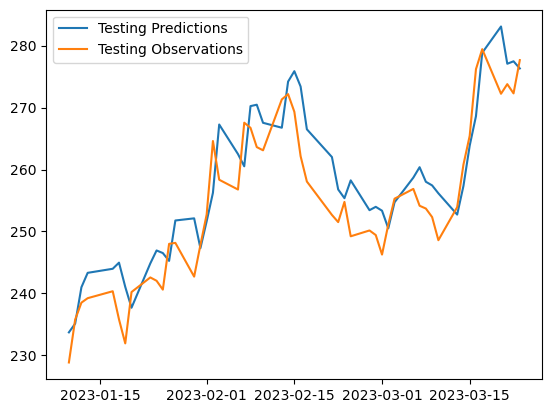

In [17]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

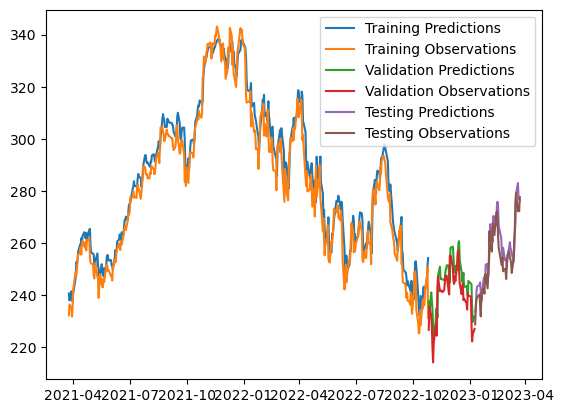

In [21]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [22]:


recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 17ms/step


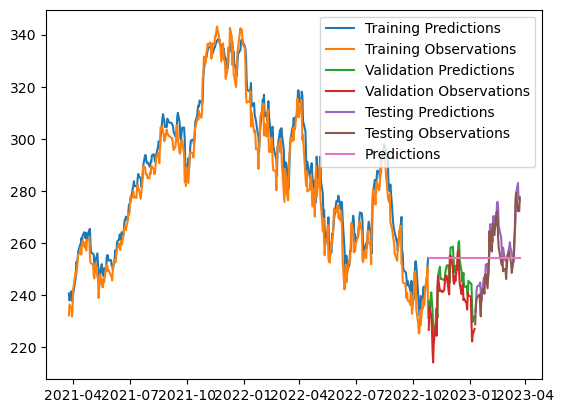

In [23]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Predictions'])